In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
from skimage.io import imread, imshow
import skimage.transform
import matplotlib.pyplot as plt

### Prepare the Dataset

In [ ]:
source_path = "/content/drive/MyDrive/Flood2/S1Hand/"
label_path = "/content/drive/MyDrive/Flood2/S1OtsuLabelHand/"

source = []
label = []
for file in os.listdir(source_path):
    if file.endswith("tif"):
      source.append(file)

for file in os.listdir(label_path):
    if file.endswith("tif"):
      label.append(file)

In [ ]:
## SAnity Check
source = sorted(source)
label = sorted(label)
print(len(source))
print(len(label))

577
577


In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 2


#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

In [ ]:
X = np.zeros((len(source), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y = np.zeros((len(label),IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

In [ ]:
# Sanity Check
print(X.shape)
print(Y.shape)

(577, 128, 128, 2)
(577, 128, 128, 1)


In [ ]:
for count, file in enumerate(source):
    source_img = imread(source_path +'/' +file ) #[0:2,:,:]
    # print(f"the shape of the source image: {source_img.shape}")
    new_image = np.transpose(source_img, (1, 2, 0))
    X[count] = new_image


for count, file in enumerate(label):
    slabel_img = imread(label_path + '/'+file ) #[:,:,:,IMG_CHANNELS]
    y = np.expand_dims(slabel_img, axis=2)
    # print(f"The shape of y labels: {y.min()}")
    Y[count] = y

<ipython-input-8-6bd12e2be714>:5: RuntimeWarning: invalid value encountered in cast
  X[count] = new_image


In [ ]:
# Sanity Check
print(X.shape)
print(Y.shape)

(577, 128, 128, 2)
(577, 128, 128, 1)


### Define the UNET

In [ ]:
#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False, name="SGD")
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 2)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 128, 128, 2)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 16)   │            304 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 16)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 32)     │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16, 16, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 128)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)       

 Total params: 1,940,961 (7.40 MB)

 Trainable params: 1,940,961 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30)

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_S2Hand.keras', verbose=1, save_best_only=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_loss'),
    checkpointer
]

results = model.fit(x_train, y_train, validation_split=0.1, batch_size=12, epochs=200, callbacks=callbacks)

Epoch 1/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.5067 - loss: 0.7386
Epoch 1: val_loss improved from inf to 0.69109, saving model to model_S2Hand.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 36s 497ms/step - accuracy: 0.5067 - loss: 0.7376 - val_accuracy: 0.5242 - val_loss: 0.6911
Epoch 2/200
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5162 - loss: 0.6923
Epoch 2: val_loss improved from 0.69109 to 0.69102, saving model to model_S2Hand.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.5161 - loss: 0.6923 - val_accuracy: 0.5242 - val_loss: 0.6910
Epoch 3/200
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5197 - loss: 0.6915
Epoch 3: val_loss did not improve from 0.69102
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5199 - loss: 0.6915 - val_accuracy: 0.5261 - val_loss: 0.6912
Epoch 4/200
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5240 - loss: 0.6917
Epoch 4: val_loss improved from 0.69102 to 0.69060, saving model to model_S2Hand.keras


### Evaluate the model on the test data

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=12)
print("test loss, test acc:", results)

Evaluate on test data
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.4887 - loss: 1.1102
test loss, test acc: [1.097011923789978, 0.4944777190685272]


In [ ]:
y_pred = model.predict(X)
y_pred_thresholded = y_pred >0.5

intersection = np.logical_and(Y, y_pred_thresholded)
union = np.logical_or(Y, y_pred_thresholded)
iou_score = np.sum(intersection)/np.sum(union)
print("IoU score is:", iou_score)

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step
IoU score is: 0.4842903984307392


### Classification Map

In [ ]:
# Use Trainned UNET model for segmenting a test image
test_img = np.expand_dims(x_test[4], axis=0)
prediction = model.predict(test_img)
prediction = prediction >0.5

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


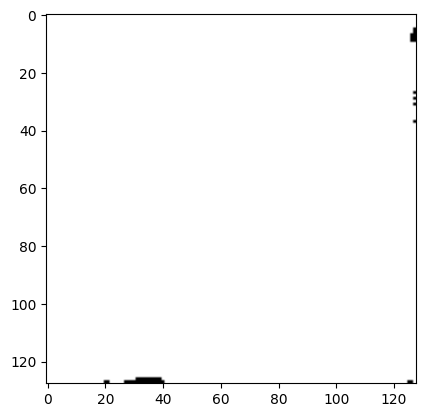

In [ ]:
# View and Save segmented image
prediction_image = prediction.reshape(128,128)
plt.imshow(prediction_image, cmap='gray')
plt.imsave('UNET_S1Hand.jpg', prediction_image, cmap='gray')

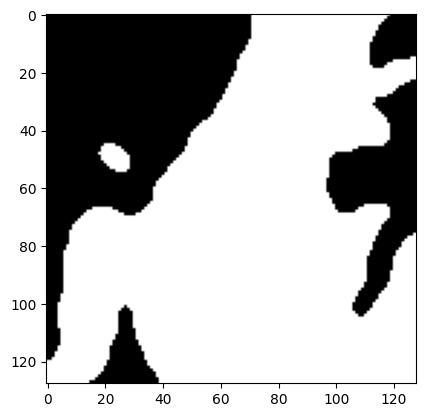

In [ ]:
# The Corresponding Ground Truth Mask
plt.imshow(y_test[4].reshape(128,128), cmap='gray')

In [ ]:
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.models import load_model

class CustomConv2DTranspose(Conv2DTranspose):
    def __init__(self, *args, **kwargs):
        if 'groups' in kwargs:
            del kwargs['groups']
        super().__init__(*args, **kwargs)

custom_objects = {'Conv2DTranspose': CustomConv2DTranspose}

In [ ]:
model_path = "/content/drive/MyDrive/Flood2/model_S1Hand.h5"
model = load_model(model_path, custom_objects=custom_objects)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Evaluate on test data
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 396ms/step - accuracy: 0.9543 - loss: 0.1096
test loss, test acc: [0.10157656669616699, 0.957863986492157]
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
IoU score is: 0.9169279051063038
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


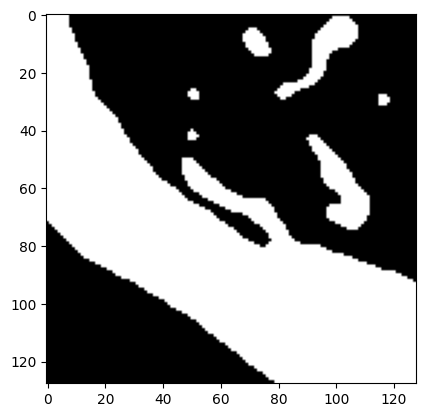

In [ ]:
# Evaluate the model
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30)

print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=12)
print("test loss, test acc:", results)

y_pred = model.predict(x_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU score is:", iou_score)

# Visualize the prediction
test_img = np.expand_dims(x_test[4], axis=0)
prediction = model.predict(test_img)
prediction = prediction > 0.5

prediction_image = prediction.reshape(128, 128)
plt.imshow(prediction_image, cmap='gray')
plt.imsave('UNET_S1Hand.jpg', prediction_image, cmap='gray')

plt.imshow(y_test[4].reshape(128, 128), cmap='gray')

Evaluate on test data
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 554ms/step - accuracy: 0.9584 - loss: 0.1065
test loss, test acc: [0.10027648508548737, 0.9606905579566956]


6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step
IoU score is: 0.9212344509310816
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


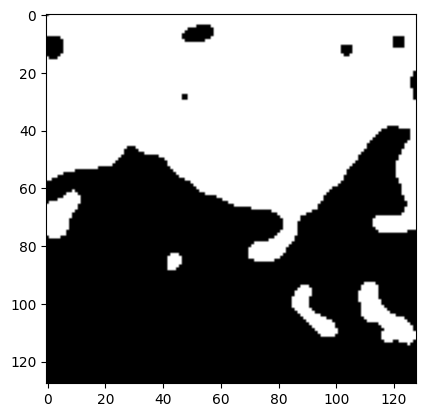

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

class CustomConv2DTranspose(Conv2DTranspose):
    def __init__(self, *args, **kwargs):
        if 'groups' in kwargs:
            del kwargs['groups']
        super().__init__(*args, **kwargs)

custom_objects = {'Conv2DTranspose': CustomConv2DTranspose}
model_path = "/content/drive/MyDrive/Flood2/model_S1Hand.h5"
model = load_model(model_path, custom_objects=custom_objects)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


np.random.seed(None)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=None)

print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=12)
print("test loss, test acc:", results)

y_pred = model.predict(x_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU score is:", iou_score)

random_index = np.random.randint(len(x_test))
test_img = np.expand_dims(x_test[random_index], axis=0)
prediction = model.predict(test_img)
prediction = prediction > 0.5

prediction_image = prediction.reshape(128, 128)
plt.imshow(prediction_image, cmap='gray')
plt.imsave('UNET_S1Hand.jpg', prediction_image, cmap='gray')

plt.imshow(y_test[random_index].reshape(128, 128), cmap='gray')
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Evaluate on test data
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9652 - loss: 0.0839
test loss, test acc: [0.09143763035535812, 0.9622676372528076]
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step
IoU score is: 0.9245955972038796
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


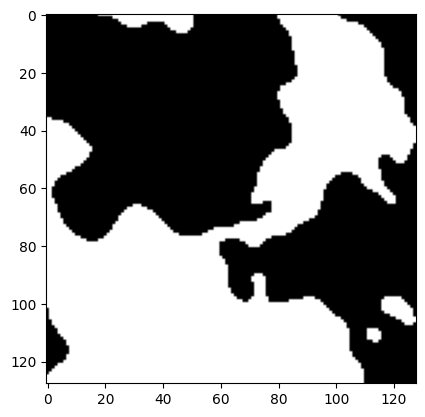

ValueError: Input shape is incorrect: (1, 128, 128, 128, 2). Expected shape: (1, 128, 128, 2).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from skimage import io, color
from skimage.transform import resize

class CustomConv2DTranspose(Conv2DTranspose):
    def __init__(self, *args, **kwargs):
        if 'groups' in kwargs:
            del kwargs['groups']
        super().__init__(*args, **kwargs)

custom_objects = {'Conv2DTranspose': CustomConv2DTranspose}
model_path = "/content/drive/MyDrive/Flood2/model_S1Hand.h5"
model = load_model(model_path, custom_objects=custom_objects)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

np.random.seed(None)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=None)

print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=12)
print("test loss, test acc:", results)

y_pred = model.predict(x_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU score is:", iou_score)

random_index = np.random.randint(len(x_test))
test_img = np.expand_dims(x_test[random_index], axis=0)
prediction = model.predict(test_img)
prediction = prediction > 0.5

prediction_image = prediction.reshape(128, 128)
plt.imshow(prediction_image, cmap='gray')
plt.imsave('UNET_S1Hand.jpg', prediction_image, cmap='gray')

plt.imshow(y_test[random_index].reshape(128, 128), cmap='gray')
plt.show()

def predict_tiff_file(tiff_path):
    img = io.imread(tiff_path)

    if len(img.shape) == 3 and img.shape[2] == 3:
        img_gray = color.rgb2gray(img)
    else:
        img_gray = img

    img_resized = resize(img_gray, (128, 128), mode='reflect')
    img_expanded = np.stack([img_resized, img_resized], axis=-1)
    img_expanded = np.expand_dims(img_expanded, axis=0)

    if img_expanded.shape != (1, 128, 128, 2):
        raise ValueError(f"Input shape is incorrect: {img_expanded.shape}. Expected shape: (1, 128, 128, 2).")

    prediction = model.predict(img_expanded)
    prediction_thresholded = prediction > 0.5

    prediction_image = prediction_thresholded.reshape(128, 128)
    plt.imshow(prediction_image, cmap='gray')
    plt.imsave('Prediction_Output.jpg', prediction_image, cmap='gray')
    plt.show()

tiff_path = "/content/drive/MyDrive/Flood2/S1Hand/Bolivia_129334_S1Hand_00128128.tif"
predict_tiff_file(tiff_path)